In [308]:
from mnist import MnistDataset as MD
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [309]:
# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
# dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# 随机种子
torch.manual_seed(3)
np.random.seed(10)

In [310]:
# 导入手写数据集
md_trian = MD(flatten=False)
md_eval =  MD(trian=False, flatten=False)


dataset_images is existing
dataset_labels is existing
dataset_images is existing
dataset_labels is existing


# 建立网络

In [311]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [312]:
class CNN_write(nn.Module):
    def __init__(self, batch_num=1, lr=1e-3):
        super().__init__()
        self.batch_num = batch_num
        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            View((batch_num,-1)),
            nn.Linear(64*4*4, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, 10),
            nn.Dropout(0.5),
            # nn.Sigmoid()
            # nn.Softmax(dim=1)
            # nn.LogSoftmax(dim=1)
        )

        # 初始化参量
        self.init_weight()

        # 定义损失函数(loss)
        # self.loss_function = nn.MSELoss()
        # self.loss_function = nn.BCELoss()
        # self.loss_function = nn.NLLLoss()     # 配合LogSoftmax()，使用标记而不是one-hot
        self.loss_function = nn.CrossEntropyLoss()  # reduction="none" 

        # 定义优化器
        # self.optimiser = torch.optim.SGD(self.parameters(),lr=lr)
        self.optimiser = torch.optim.Adam(self.parameters(),lr=lr)

        # 计数器,loss进程记录,accuracy进程记录
        self.counter = 0
        self.LOSSprogress = []
        self.ACCprogress = []

    def init_weight(self):
        # modules() : Returns an iterator over all modules in the network.
        # a = np.sqrt(5)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0]*m.kernel_size[1]*m.in_channels
                # wight_init_scales = np.sqrt(2.0/n)
                # bound = np.sqrt(3/(1+a*a))*wight_init_scales
                # m.weight.data = torch.sqrt(2./n)*torch.normal(mean=0, std=1,size=m.weight.shape)
                # with torch.no_grad():
                    # m.weight.normal_(0, wight_init_scales) # 0, np.sqrt(2./n)
                    # m.weight.uniform_(-bound,bound)
                # torch.nn.init.kaiming_uniform_(m.weight,a=np.sqrt(5))
                torch.nn.init.kaiming_normal_(m.weight,a=np.sqrt(5))
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
                    # with torch.no_grad():
                    #     m.bias.zero_()
                        # m.bias.uniform_(-0.1,0.1)
                    # torch.nn.init.uniform_(m.bias, -0.1, 0.1)

            if isinstance(m, nn.Linear):
                # n = m.in_features
                # wight_init_scales = np.sqrt(2.0/n)
                # bound = np.sqrt(3/(1+a*a))*wight_init_scales
                # m.weight.data = torch.sqrt(2./n)*torch.normal(mean=0, std=1,size=m.weight.shape)
                # with torch.no_grad():
                    # m.weight.normal_(0, wight_init_scales) # 0, np.sqrt(2./n)
                    # m.weight.uniform_(-bound,bound)
                # torch.nn.init.kaiming_uniform_(m.weight,a=np.sqrt(5))
                torch.nn.init.kaiming_normal_(m.weight,a=np.sqrt(5))
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
                    # with torch.no_grad():
                    #     m.bias.zero_()
                        # m.bias.uniform_(-0.1,0.1)
                    # torch.nn.init.uniform_(m.bias, -0.1, 0.1)
        
    def forward(self, x):       
        return self.model(x)
    
    def trained(self, inputs, targets):
        outputs = self.forward(inputs)  # 网络输出值
        # out_max = torch.max(outputs,dim=1)[0]   # 找出每批中的最大值
        # out_max = out_max.reshape(outputs.shape[0],-1)  # 转置
        # outputs = outputs-out_max        # 使用softmax防止溢出
        loss = self.loss_function(outputs,targets)  # 损失值

        # 每训练10次增加计数器
        if (self.counter % 1 == 0):    self.LOSSprogress.append(loss.item())
        # if (self.counter % 10000 == 0): print("counter = ", self.counter)

        # =================== 使用损失值更新权重 ===================
        self.optimiser.zero_grad()  # 将图中的梯度全部归零
        loss.backward()             # 计算网络中的梯度
        self.optimiser.step()       # 更新网络中可学习的参数

        self.counter += 1

    def accuracy(self, ims, labels, file_Test = r'./test_error_correct.txt'):
        self.eval()
        per_datset = int(ims.shape[0]/self.batch_num)    # 每个数据集用的批次数
        acc = 0.0       # 测试精度初始化
        error_num = 0   # 错误数量
        with open(file_Test, "w") as f:
            f.write("序号\tlabel\tlabels_correct\n")
            for i in range(per_datset-1): 
                outputs = self.forward(ims[i*self.batch_num:(i+1)*self.batch_num])
                tt = labels[i*self.batch_num:(i+1)*self.batch_num]
                outputs = outputs.cpu().detach().numpy()     # 网络输出值
                y = np.argmax(outputs, axis=1)
                acc += np.sum(y == tt)
             
                # 保存错误的位置，识别标签，正确标签
                error = np.where((y != tt)==1)
                error_num += np.sum(y != tt)
                for er in error[0]:
                    f.write("{}\t{}\t{}\n".format(er+i*self.batch_num, y[er], tt[er]))

            acc = acc/ims.shape[0]

            f.write(f"总数量：{ims.shape[0]}；识别错误的个数：{error_num}；测试学习的成功率为：{acc}\n")
            
        self.train() 

        return acc
    
    def accuracy_progress(self, ims, labels):
        self.eval()
        per_datset = int(ims.shape[0]/self.batch_num)    # 每个数据集用的批次数
        acc = 0.0       # 测试精度初始化
        for i in range(per_datset-1):
            outputs = self.forward(ims[i*self.batch_num:(i+1)*self.batch_num])
            tt = labels[i*self.batch_num:(i+1)*self.batch_num]
            outputs = outputs.cpu().detach().numpy()     # 网络输出值
            y = np.argmax(outputs, axis=1)
            acc += np.sum(y == tt)

        acc = acc/ims.shape[0]
        if (self.counter % 1 == 0):    self.ACCprogress.append(acc) 
        self.train()  

    def plot_progress(self):
        fig, ax = plt.subplots(1,2,figsize=(8, 4))
        fig.suptitle("progress",x=0.5,y=0.99,size=15,weight='bold')
        fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.85, wspace=0.2,
        hspace=0.1)
        # loss
        ax[0].scatter(np.arange(1, int(self.counter/1)+1),self.LOSSprogress,s=10,c="tab:pink",label="loss")
        ax[0].set_xlabel("time") 
        ax[0].set_ylabel("loss") 
        ax[0].set_title("loss")
        # accuracy
        ax[1].plot(np.arange(1, int(self.counter/1)+1),self.ACCprogress,c="tab:pink",label="loss")
        ax[1].set_xlabel("time") 
        ax[1].set_ylabel("accuracy")
        ax[1].set_title("accuracy")

        plt.show()
    
    def save_params(self, file_name="params.pt"):
        torch.save(self.state_dict(),file_name)

    def load_params(self, file_name="params.pt"):
        self.load_state_dict(torch.load(file_name))

        

In [313]:
# 实例化网络
batch_num = 100        # 批次大小
lr = 1e-3               # 学习率
CNN = CNN_write(batch_num,lr=lr).to(device)
print("=======创建网络成功=======\n")
# CNN.save_params()
# CNN.load_params()
# CNN.train()
# CNN.eval()
# CNN.training = False
# CNN.training
# CNN(im).shape
# o = CNN(im)
# print(o)
# print(list(CNN.parameters())[8])
# print(*CNN.named_parameters())
# for w in CNN.parameters():
#     print(w.shape)
# print(list(CNN.state_dict())[8])
# print(*CNN.model.parameters())
# print(*CNN.model.named_parameters())
# print(*CNN.model.state_dict())
# CNN.loss_function(o,target)
# for m in CNN.modules():
#     if isinstance(m, nn.ReLU):
#         print(m)



=======创建网络成功=======



In [314]:
# 训练网络
epochs = 50    # 设定世代数
lens = len(md_trian)
per_epoch = int(lens/batch_num)    # 每个世代用的批次数
label_all, im_all, targets_all = md_eval[:] # 所有的测试数据
CNN.train()                 # 开启训练

# 训练开始
for e in range(epochs):
    # 训练进度可视化
    if e%1==0:    print("\r", "学习进度：{:.3f} %".format((e+1)*100/epochs), end='', flush=True)
    # 随机打乱每个批次中的数据顺序
    num_dat = np.random.permutation(np.arange(lens))
    for i in range(per_epoch-1):   
        id_batch = num_dat[i*batch_num:(i+1)*batch_num]
        labels, im, targets = md_trian[id_batch]
        CNN.trained(im.to(device),targets.to(device))
        CNN.accuracy_progress(im_all.to(device), label_all)


 学习进度：100.000 %

0.9816


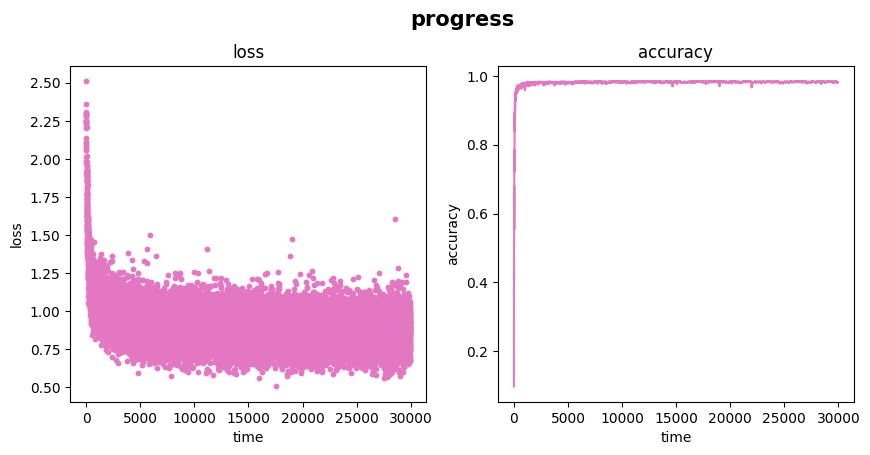

In [315]:
CNN.eval()      # 开启评估
# a=np.arange(10,20)
# b=np.random.permutation(a)
# label, im, targets = md_trian[b]
# print(b)
# im.shape
# len(md_trian)
# labels, im, targets = md_trian[:]
labels, im, targets = md_eval[:]
print(CNN.accuracy(im.to(device), labels))
CNN.plot_progress()
# labels.shape